In [4]:
from kevlib import common_import_script
%run $common_import_script
from astropy.coordinates import SkyCoord
from astroscrappy import detect_cosmics
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import lmfit
from astropy.io import fits
from kevlib.utils.plot import plot_images
from glob import glob
import kevlib.image as kli
from kevlib.utils import fix_byte_order
import urllib.parse
from astropy.io import ascii as astro_ascii
from scipy.ndimage import binary_dilation, binary_erosion
import shapely
from shapely.geometry import Polygon, Point

def is_point_inside_bounding_area(bounding_points, point_to_check):
    polygon = Polygon(bounding_points)
    
    point = Point(point_to_check)
    
    return polygon.contains(point)
def maskImage(path, showImage=False):
    single_path = path
    im_single = fix_byte_order(fits.getdata(single_path))

    s_bkg, s_rms = kli.background.measure_bkg_and_rms(
        im_single, meas_window_size=[10]*2, outlier_sigma=3,
        blur_sigma=20, blur_kernel_size=31, device='cpu'
    )
    im_single_br = im_single - s_bkg

    # Infill NaNs from the start
    im_single_c = kli.nan_infill(im_single_br, s_rms)

    # Make coadd
    im_coadd = kli.wise.make_wise_coadd(single_path)

    c_bkg, c_rms = kli.background.measure_bkg_and_rms(
        im_coadd, meas_window_size=[10]*2, outlier_sigma=3,
        blur_sigma=20, blur_kernel_size=31, device='cpu'
    )
    im_coadd_br = im_coadd - c_bkg

    c_obj_map = im_coadd_br > 0.5
    c_obj_map = binary_dilation(binary_erosion(c_obj_map, iterations=1), iterations=2)

    nan_fill_mask = np.zeros_like(im_single, dtype=bool)

    im_single_masked = im_single_c.copy()
    im_single_masked[c_obj_map] = np.nan
    nan_fill_mask[c_obj_map] = True

    s_bkg, s_rms = kli.background.measure_bkg_and_rms(
        im_single_masked, meas_window_size=[10]*2, outlier_sigma=3,
        blur_sigma=20, blur_kernel_size=31, device='cpu'
    )

    s_b = im_single_masked - s_bkg
    s_i = kli.nan_infill(s_b, s_rms)

    constant_scaler = 5
    s_norm = s_i.copy()

    low_px_mask = s_norm < -3 * s_rms
    s_norm[low_px_mask] = np.nan
    nan_fill_mask[low_px_mask] = True

    

    s_norm = kli.nan_infill(s_norm, s_rms)
    s_norm /= (s_rms * constant_scaler)


    
    if showImage:
        axs = plot_images(
            ims=[im_single_c, s_norm, s_i, im_coadd, nan_fill_mask.astype(float)], 
            title=None, norm_same=False, fig_height=4,
            imshow_kwargs=dict(cmap='viridis')
        )
        [ax.set_title(t) for ax, t in zip(
            axs, ['Single', 'Final Normalized', 'Infilled', 'Coadd', 'NaN Fill Mask']
        )]

    return s_norm, im_coadd, im_single, nan_fill_mask


import numpy as np
from PIL import Image

def grid_image(image_array, square_size):
    corners = []

    image = Image.fromarray(image_array)


    width, height = image.size


    num_squares_x = width // square_size
    num_squares_y = height // square_size

    squares = []

    for i in range(num_squares_x):
        for j in range(num_squares_y):
            left = i * square_size
            upper = j * square_size
            right = (i + 1) * square_size
            lower = (j + 1) * square_size


            square = image.crop((left, upper, right, lower))
            # if left == 0:
            #     print(left, upper, right, lower)
            
            # Convert the square to a NumPy array and append to the list
            square_array = np.array(square)
            squares.append(square_array)

            # midpt = midpoint(left, upper, right, lower)
            corners.append([left,upper])
            # print("corner: ", left, upper)

    return squares, corners

good_speed_chains = []

with open('stspaper_good_speed_chains_4and5.txt', 'r') as f:
    for line in f:

        sublist = list(map(int, line.strip().split()))
        if len(sublist) >=4:
            good_speed_chains.append(sublist)

good_angle_chains = [1, 5, 10, 12, 13, 22, 26, 29, 33, 35, 40, 45, 47, 55, 58, 63, 70, 74, 78, 80, 85, 86, 87, 91, 92, 107, 109, 114, 119, 120, 123, 126, 127, 130, 134, 138, 139, 148, 149, 151, 154, 157, 164, 166, 168, 178, 181, 185, 194, 198, 203, 208, 210, 228, 229, 234, 236, 238, 242, 247, 268, 279, 310, 317, 327, 328, 336, 337, 345, 348, 351, 352, 357, 359, 361, 369, 370, 373, 382, 386, 400, 405, 417, 419, 420, 424, 431, 434, 435, 440, 450, 457, 462, 477, 480, 497, 508, 512, 516, 521, 532, 538, 539, 543, 557, 558, 561, 562, 570, 575, 577, 586, 587, 594, 599, 601, 609, 611, 613, 614, 616, 618, 619, 621, 622, 632, 653, 657, 671, 672, 673, 683, 694, 697, 704, 708, 710, 712, 715, 716, 717, 727, 728, 734, 735, 737, 740, 747, 766, 779, 791, 795, 802, 804, 811, 812, 819, 821, 822, 830, 832, 845, 853, 854, 862, 863, 865, 868, 877, 889, 892]

good_speed_angle_chains = [good_speed_chains[i] for i in range(len(good_speed_chains)) if i in good_angle_chains]
len(good_speed_angle_chains)

ims = np.load("./Searches/v1_images_pt4.npy")
pix_coords = np.load("./Searches/v1_predicted_CoordinatesPixels_pt4.npy")

all_ims = []
patches = []
patch_size=4
for tracklet in good_speed_angle_chains:
    for idx in tracklet:
        im = ims[idx]
        all_ims.append(im)
        
        
        H, W = (15,15)
        half = patch_size // 2
   
        x, y = int(pix_coords[idx][0]), int(pix_coords[idx][1])

        x_start = np.clip(x - half, 0, W - patch_size)
        y_start = np.clip(y - half, 0, H - patch_size)

        patch = im[y_start:y_start + patch_size, x_start:x_start + patch_size]
        patches.append(patch)


def split_15x15_to_4x4(all_grids):
    """
    Takes an array/list of 15x15 patches and splits each into 4x4 sub-patches.
    Returns a NumPy array of shape (num_patches * 9, 4, 4).
    """
    small_patches = []

    for patch in all_grids:
        h, w = patch.shape[:2]
        for y in range(0, h - 3, 4):
            for x in range(0, w - 3, 4):
                small = patch[y:y+4, x:x+4]
                small_patches.append(small)

    return np.array(small_patches)


---------------------------------------------------------------------------------------
|                        Last run date: 2025-08-29 08:04 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.4.3    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


In [ ]:
"""
1. get all search region links
2. process one
3. cutout one
4. check binary mask of pixel edits for each cutout

In [58]:
urls = np.load("./Searches/S1_URLs.npy")

In [61]:
urls = np.unique(urls)

In [93]:
masks = []

for url in tqdm(urls):
    n, c, s, mask = maskImage(url)
    masks.append(mask)
    
all_grids = []

# create grid masks of 15px width
for mask in masks:
    cutout, _ = grid_image(mask, 15)
    for square in cutout:
        all_grids.append(square)

sums = [all_grids[i].sum() for i in range(len(all_grids))]

# create grid masks of 4px width
all_grids_4px = []
for mask in masks:
    cutout, _ = grid_image(mask, 4)
    for square in cutout:
        all_grids_4px.append(square)
sums_4px = [all_grids_4px[i].sum() for i in range(len(all_grids_4px))]


# plotting:
# plt.figure(figsize=(8,4))
# plt.hist(sums_4px,bins=15)
# plt.xticks(np.arange(min(sums_4px), max(sums_4px), 1)) # Example: ticks every 0.5 units
# plt.title("Example Searched Frame: Background Star+Artifact Masked Images", fontsize=14)
# plt.xlabel("Number of Edited Pixels", fontsize=14)
# plt.ylabel("Number of Cutout Images",fontsize=14)

np.save("./Searches/binary_masked_grids_15px", all_grids)
np.save("./Searches/binary_masked_grids_4px", all_grids_4px)
np.save("./Searches/binary_masks_full", masks)



np.save("./Searches/bks_15px_sums", sums)
np.save("./Searches/bkgs_4px_sums", sums_4px)


  0%|          | 0/755 [00:00<?, ?it/s]

In [92]:
len(g_idxs_4px)

89669

In [2]:
# import numpy as np

# import numpy as np

# def stitch_from_cutouts(all_cutouts, num_x, num_y, square_size=15):
#     cutouts_per_frame = num_x * num_y
#     num_frames = len(all_cutouts) // cutouts_per_frame

#     frames = []
#     for f in range(num_frames):
#         start = f * cutouts_per_frame
#         end = (f+1) * cutouts_per_frame
#         cutouts = all_cutouts[start:end]

#         rows = []
#         for j in range(num_y):
#             row = np.concatenate(cutouts[j*num_x:(j+1)*num_x], axis=1)
#             rows.append(row)
#         full_frame = np.concatenate(rows, axis=0)
#         frames.append(full_frame)

#     return frames


# num_x = 1016 // 15
# num_y = 1016 // 15

# full_frames = stitch_from_cutouts(all_searched_cutouts, num_x, num_y, 15)

# squares_4x4 = []
# for f in full_frames:
#     squares_4x4.append(grid_image(f, 4))

In [ ]:
len(squares_4x4), len(all_searched_cutouts)

In [74]:

g_idxs = [i for i in range(len(sums)) if sums[i] <=3]
g_idxs

[4,
 5,
 13,
 14,
 18,
 22,
 23,
 24,
 27,
 29,
 30,
 33,
 35,
 38,
 40,
 41,
 43,
 44,
 48,
 49,
 58,
 59,
 61,
 63,
 64,
 65,
 66,
 67,
 71,
 72,
 74,
 76,
 81,
 83,
 84,
 86,
 90,
 91,
 92,
 102,
 111,
 112,
 113,
 118,
 121,
 123,
 129,
 130,
 131,
 132,
 135,
 136,
 138,
 141,
 142,
 144,
 146,
 151,
 152,
 153,
 154,
 155,
 157,
 158,
 159,
 160,
 164,
 169,
 170,
 172,
 177,
 178,
 185,
 190,
 192,
 193,
 202,
 203,
 205,
 206,
 207,
 213,
 216,
 218,
 222,
 226,
 231,
 233,
 234,
 236,
 240,
 244,
 247,
 252,
 253,
 254,
 270,
 273,
 274,
 283,
 285,
 286,
 287,
 288,
 292,
 293,
 298,
 299,
 304,
 311,
 319,
 322,
 324,
 327,
 331,
 335,
 336,
 337,
 338,
 340,
 341,
 342,
 343,
 344,
 345,
 348,
 353,
 355,
 359,
 360,
 361,
 363,
 366,
 370,
 371,
 372,
 373,
 374,
 377,
 378,
 380,
 381,
 396,
 397,
 398,
 402,
 403,
 405,
 406,
 408,
 412,
 413,
 414,
 417,
 421,
 424,
 430,
 433,
 435,
 438,
 446,
 456,
 457,
 458,
 465,
 470,
 472,
 481,
 490,
 494,
 495,
 496,
 497,
 50

In [ ]:
"""
1. load binary masks of 15x15 pixels
2. load images of 15x15 pixels (searched)
3. cut binary masks and images into 4x4 pixels
4. 
"""

In [16]:
"""
given a 15x15 image in a python array of many such images:
1. crop it to 4x4 patch in the center
2. count how many true value pixels there are
3. append index value current to an array g_idxs
"""
all_grids = np.load("./Searches/binary_masked_grids_15px.npy")

def find_true_counts(all_grids):
    """
    all_grids: numpy array of shape (N, 15, 15) or (N, 15, 15, C)
    Returns: list of indices where the center 4x4 patch has True pixels
    """
    g_idxs = []

    for idx, patch in enumerate(all_grids):
        h, w = patch.shape[:2]
        start_y = (h - 4) // 2
        start_x = (w - 4) // 2
        center_patch = patch[start_y:start_y+4, start_x:start_x+4]

        if np.sum(center_patch) <= 1:
            g_idxs.append(idx)

    return g_idxs

g_idxs = find_true_counts(all_grids)


In [8]:
len(all_grids)

3389195

In [13]:
all_grids = np.load("./Searches/binary_masked_grids_15px.npy")

# masks_4px = split_15x15_to_4x4(all_grids)

# all_searched_cutouts = np.load("./Searches/2_S1_DarkPixelsRemoved_Normalized_FinalDeployGrids.npy")

# ims_4px = split_15x15_to_4x4(all_searched_cutouts)


In [18]:
all_searched_grids = np.load("./Searches/2_S1_DarkPixelsRemoved_Normalized_FinalDeployGrids.npy")
# ims_4px = split_15x15_to_4x4(all_searched_grids)


In [9]:

sums = [masks_4px[i].sum() for i in range(len(masks_4px))]
g_idxs = [i for i in range(len(sums)) if sums[i] <=3]

g_idxs

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 14,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 140,
 142,
 143,
 144,
 147,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 176,
 177,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 190,
 191,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 2

In [11]:
unedited_search_cutouts = [ims_4px[i] for i in g_idxs]
# unedited_search_cutouts_fulls = [all_searched_grids[i] for i in g_idxs]

In [12]:
len(unedited_search_cutouts)

25407095

In [102]:
# plot_images(all_searched_cutouts[-1])

In [25]:
# plot_images(patches[4])

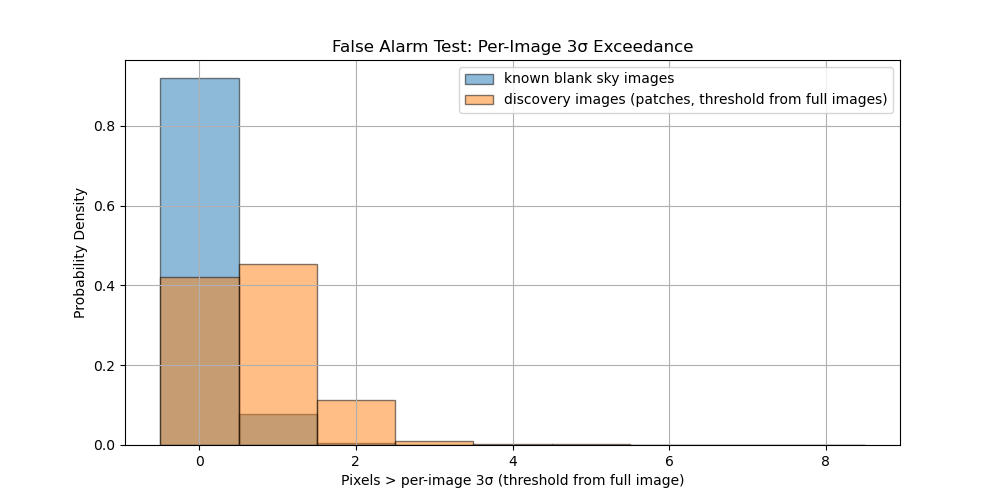

In [46]:

import numpy as np
import matplotlib.pyplot as plt

plt.close()
plt.figure(figsize=(10,5))

# A_full = np.load("./TrainingData/FalseSet/280k_blank_false_images.npy")  # (N, 15, 15)
A_full = [all_searched_grids[i] for i in g_idxs]

A_full = np.array(A_full)
A_crop = A_full[:, 6:10, 6:10]



means_false = A_full.mean(axis=(1, 2))
stds_false = A_full.std(axis=(1, 2))
thresholds_false = means_false + 3 * stds_false
thresholds_false = thresholds_false[:, np.newaxis, np.newaxis]

count_above_3sigma_false = np.sum(A_crop > thresholds_false, axis=(1, 2))

plt.hist(count_above_3sigma_false, bins=np.arange(0, 10)-0.5, edgecolor='black', alpha=0.5,
         label="known blank sky images", density=True)






# all_ims: full images corresponding to patches
all_ims = np.array(all_ims) # (M, 15, 15)
patches = np.array(patches)# (M, 4, 4)

means_all = all_ims.mean(axis=(1, 2))
stds_all = all_ims.std(axis=(1, 2))
thresholds_all = means_all + 3 * stds_all
thresholds_all = thresholds_all[:, np.newaxis, np.newaxis]  # shape (M,1,1)

count_above_3sigma_patches = np.sum(patches > thresholds_all, axis=(1, 2))

plt.hist(count_above_3sigma_patches, bins=np.arange(0, 10)-0.5, edgecolor='black',
         label="discovery images (patches, threshold from full images)", density=True, alpha=0.5)

plt.xlabel('Pixels > per-image 3sigma (threshold from full image)')
plt.ylabel('Probability Density')
plt.legend()
plt.title('False Alarm Test: Per-Image 3σ Exceedance')
plt.grid(True)
plt.show()


In [38]:
print(np.sort(total_brightness))

[-128.96909  -69.63119  -59.82145 ... 2191.7505  2498.9548  2727.9167 ]


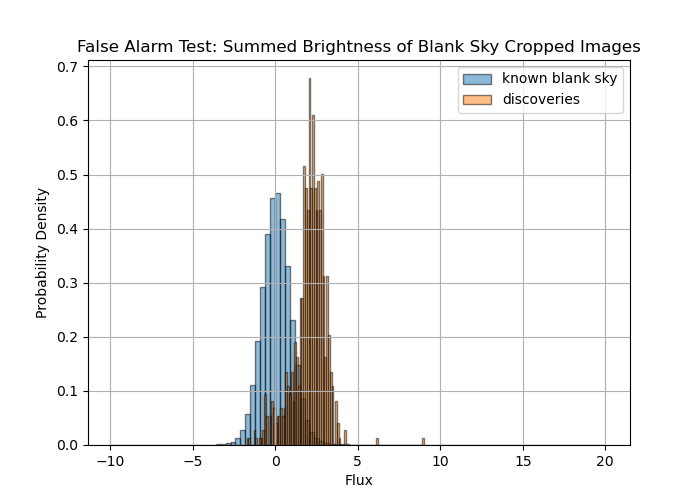

In [45]:

plt.close()
plt.figure(figsize=(7,5))
total_brightness = np.sum(A_crop, axis=(1, 2))
plt.hist(total_brightness[(total_brightness <= 20) & (total_brightness >=-10)], edgecolor='black', bins=100, label="known blank sky",density=True,alpha=0.5)

total_brightness = np.sum(patches, axis=(1, 2))
plt.hist(total_brightness[total_brightness <= 20], edgecolor='black', bins=100,label="discoveries",density=True,alpha=0.5)


plt.xlabel('Flux')
plt.ylabel('Probability Density')
plt.title('False Alarm Test: Summed Brightness of Blank Sky Cropped Images')
plt.grid(True)
plt.legend()
plt.show()
